<a href="https://colab.research.google.com/github/SriramyaK/Data-Visualizations/blob/master/Supply_vs_Demand_housing_prices_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import pandas as pd
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns # data visualization library
import datetime
sns.set(style="darkgrid")

housing = pd.read_csv("Sales_and_demand.csv",parse_dates=True)
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       241 non-null    object 
 1   HPI                        241 non-null    float64
 2   Unemployment Rate          241 non-null    float64
 3   GDP                        241 non-null    float64
 4   Inventory                  241 non-null    float64
 5   Consumer Confidence Index  241 non-null    float64
 6   Housing Starts             241 non-null    float64
 7   Permits_cust               241 non-null    float64
 8   Population                 241 non-null    float64
 9   Interest Rates             241 non-null    float64
 10  Mortgage                   241 non-null    float64
dtypes: float64(10), object(1)
memory usage: 21.8+ KB


In [162]:
housing['Year_parsed'] =  pd.to_datetime(housing['Year'])
housing['Year'] = housing['Year_parsed'].dt.year
housing['Month'] = housing['Year_parsed'].dt.month
housing.drop(columns=['Year_parsed'],inplace=True)

In [163]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       241 non-null    float64
 1   HPI                        241 non-null    float64
 2   Unemployment Rate          241 non-null    float64
 3   GDP                        241 non-null    float64
 4   Inventory                  241 non-null    float64
 5   Consumer Confidence Index  241 non-null    float64
 6   Housing Starts             241 non-null    float64
 7   Permits_cust               241 non-null    float64
 8   Population                 241 non-null    float64
 9   Interest Rates             241 non-null    float64
 10  Mortgage                   241 non-null    float64
 11  Month                      241 non-null    float64
dtypes: float64(12)
memory usage: 23.8 KB


In [164]:
housing.dropna(inplace=True)

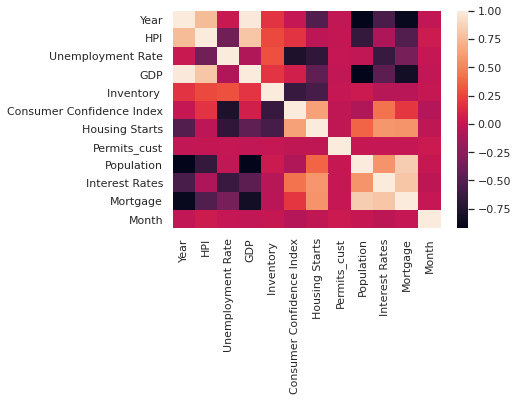

In [165]:
numeric_analysis = housing.corr()
sns.heatmap(numeric_analysis)

In [166]:
y = housing['HPI']
x = housing.drop(columns='HPI')

In [167]:
x.shape, y.shape

((241, 11), (241,))

In [168]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

In [169]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((192, 11), (49, 11), (192,), (49,))

In [170]:
trainX = pd.DataFrame(x_train)
trainX['target'] = y_train

testX = pd.DataFrame(x_test)
testX['target'] = y_test

In [171]:
trainX.to_csv('housing_train.csv')
testX.to_csv('housing_test.csv')

In [172]:
%%writefile script.py

import argparse
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.metrics import explained_variance_score, r2_score



# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

if __name__ =='__main__':

    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument('--n-estimators', type=int, default=100)
    parser.add_argument('--max_leaf_nodes', type=int, default=10)
    

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--train-file', type=str, default='housing_train.csv')
    parser.add_argument('--test-file', type=str, default='housing_test.csv')
    
    args, _ = parser.parse_known_args()
    
    print('reading data')
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print('building training and testing datasets')
    
    X_train = train_df
    X_test = test_df
    y_train = train_df['target']
    y_test = test_df['target']
    
    # train
    print('training model')
    model = RandomForestRegressor(
        n_estimators=args.n_estimators,
        max_leaf_nodes =args.max_leaf_nodes,
        n_jobs=-1)
    
    model.fit(X_train, y_train)
     
    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print('model persisted at ' + path)
    
    # print explained_variance_score 
    print('validating model')
    predictions = model.predict(X_test)
    print("Explained Variance Score is " + str(explained_variance_score(y_test, predictions).round(2)))
    print("R2 score : %.2f" % r2_score(y_test,predictions))

Overwriting script.py


In [175]:
! python script.py --n-estimators 100 \
                   --max-leaf-nodes 8 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
extracting arguments
reading data
building training and testing datasets
training model
model persisted at ./model.joblib
validating model
Explained Variance Score is 0.99
R2 score : 0.99
